# Continuous Control by Layer

In this notebook we will perform numerical simulations to determine the 
controllability of GPT-2 by layer. Consider a subset `Block` consisting of 
layers from GPT-2. 

`Block` maps from inputs in $\mathbb R^{N \times d}$ to outputs in the same $\mathbb
R^{N\times d}$ where $N$ is the number of tokens in the input and $d$ is the
dimensionality of the model (gpt2 is 768). 

## Control Preliminaries

Let $m$ be the number of fixed input tokens and $k$ be the number of control
tokens. Given some fixed input $\mathbf X\in \mathbb R^{m\times d}$ and control
input $\mathbf U \in \mathbb R^{m\times d}$, we can subdivide block $B$'s input
and output as

$$
B(\begin{bmatrix}
\mathbf U \\ 
\mathbf X
\end{bmatrix}) =:
\begin{bmatrix} 
\mathbf U' \\ 
\mathbf Y 
\end{bmatrix}
$$

As in [arXiv:2310:04444](https://arxiv.org/abs/2310.04444), our goal is to 
select $\mathbf U$ s.t. $\mathbf Y = \mathbf Y^*$ where $\mathbf Y^*$ is the 
desired output. We are interested in bounded control inputs $\mathbf U$ with
rows satsifying $\|\mathbf u_i\| \leq M_u$. 


## Continuous Control Defininition

Given some imposed $\mathbf X$ and $\delta$, let 

$$
\begin{bmatrix}
\mathbf U'_0 \\
\mathbf Y_0
\end{bmatrix}
:= B(\begin{bmatrix} 
\mathbf 0 \\ 
\mathbf X
\end{bmatrix})
$$

and let $\mathbf Y^* \sim Y_0 + \delta \mathcal N(0, 1)$. We will compute 
$$
\epsilon = \Pr\{\mathbf Y^* \in \mathcal R_y^k(\mathbf X)\}
$$

by sampling many $\mathbf Y^*$ and using projected gradient descent to find 
$\mathbf U$ that reach $\mathbf Y^*$ under magnitude constraint $\|\mathbf u_i\|
\leq M_u$. 

We are interested in how $\epsilon$ scales with the number of GPT-2 layers in `Block` $B$.


In [9]:
# Import box 
import torch 
import numpy 
import transformers 
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForCausalLM
# import functional as F 
import torch.nn.functional as F

In [10]:
# load model 
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

print(f"Model {model_name} loaded with d_model = {model.transformer.wte.weight.shape[1]}")

Model gpt2 loaded with d_model = 768


In [11]:
input_ids = tokenizer.encode("Hi, my name is GPT-2.", return_tensors="pt")
output = model(input_ids, 
               labels=input_ids, 
               return_dict=True, 
               output_hidden_states=True, 
               output_attentions=True)

print(output.keys())

odict_keys(['loss', 'logits', 'past_key_values', 'hidden_states', 'attentions'])


In [12]:
output.hidden_states[0].shape

torch.Size([1, 10, 768])

## Retrieving a Block

Let's start with the 0th block in GPT-2 and make sure we are able to feed through 
any desired $\mathbf X \in \mathbb R^{m\times d}$, $\mathbf U \in \mathbb R^{k\times d}$

input_repr shape:  torch.Size([1, 13, 768])
Y_0 shape:  torch.Size([1, 10, 768])
U_prime shape:  torch.Size([1, 3, 768])
input mags shape:  torch.Size([1, 13])


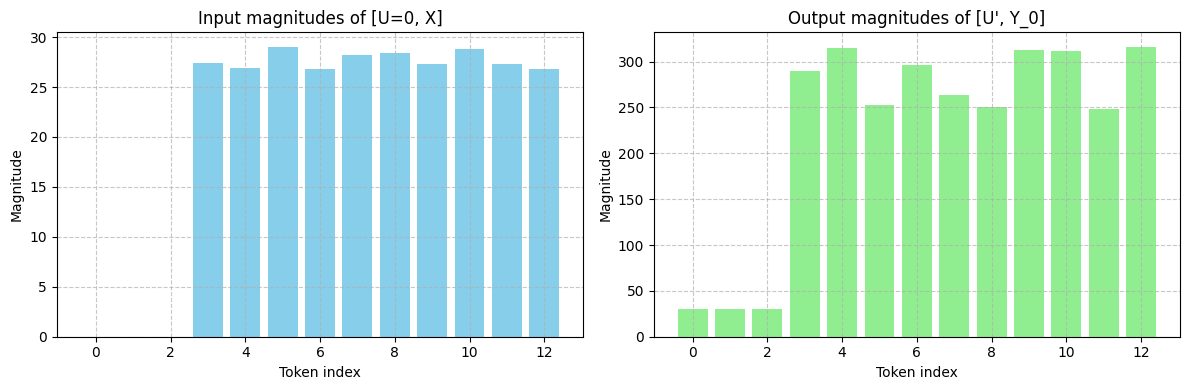

In [13]:
block_0 = model.transformer.h[0]

# generate X, U
k = 3
m = 10
U = torch.zeros(1, k, 768)
X = torch.randn(1, m, 768)

# normaliize X to zero mean, unit variance
X = F.layer_norm(X, X.shape[1:], eps=1e-5)

# compute block output given concatenated X, U along dimension 1
input_repr = torch.cat([U, X], dim=1)
print("input_repr shape: ", input_repr.shape)

with torch.no_grad():
    output = block_0(input_repr)[0]
Y_0 = output[:, -m:, :]
U_prime = output[:, :k, :]
print("Y_0 shape: ", Y_0.shape)
print("U_prime shape: ", U_prime.shape)
# print magnitude of input_repr per token, magnitude of output_repr per token 
input_mags = torch.norm(input_repr, dim=-1)
output_mags = torch.norm(output, dim=-1)
print("input mags shape: ", input_mags.shape)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the input magnitudes
ax1.bar(range(m+k), input_mags[0, :].numpy(), color='skyblue')
ax1.set_xlabel("Token index")
ax1.set_ylabel("Magnitude")
ax1.set_title("Input magnitudes of [U=0, X]")
ax1.grid(True, linestyle='--', alpha=0.7)

# Plot the output magnitudes
ax2.bar(range(m+k), output_mags[0, :].numpy(), color='lightgreen')
ax2.set_xlabel("Token index")
ax2.set_ylabel("Magnitude")
ax2.set_title("Output magnitudes of [U', Y_0]")
ax2.grid(True, linestyle='--', alpha=0.7)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

As expected, the magnitudes of tokens in $X$ is roughly $\sqrt{d} = \sqrt{768}\approx 27$. We also observe a sensible result that the outputs corresponding to $\mathbf U = 0$ are much smaller than the outputs corresponding to $\mathbf Y \sim \mathcal N(0, 1)$

Now let's try sampling a $\mathbf Y^*$ and seeing if we can optimize a $\mathbf U$ to 
get epsilon-close to $\mathbf Y^*$. 

In [14]:
delta = 1e-3

Y_star = Y_0 + delta * torch.randn(Y_0.shape)
print("Y_star shape: ", Y_star.shape)
print("Initial loss (l2 distance from Y_star to Y_0): ", torch.norm(Y_star - Y_0).item())

Y_star shape:  torch.Size([1, 10, 768])
Initial loss (l2 distance from Y_star to Y_0):  0.08826395124197006


In [15]:
# Define U as a learnable parameter
U = torch.nn.Parameter(torch.zeros(1, k, 768))

# Define the optimizer (e.g., Adam)
optimizer = torch.optim.Adam([U], lr=1e-4)

# Define the number of optimization steps
num_steps = 1000
print_steps = 100

# Perform optimization
for step in range(num_steps):
    # Zero the gradients
    optimizer.zero_grad()
    
    # Concatenate U and X along dimension 1
    input_repr = torch.cat([U, X], dim=1)
    
    # Forward pass through the block
    output = block_0(input_repr)[0]
    
    # Extract Y from the output
    Y = output[:, -m:, :]
    
    # Compute the L2 loss between Y_star and Y
    loss = torch.norm(Y_star - Y)
    
    # Backward pass and optimization step
    loss.backward()
    optimizer.step()
    
    # Print the loss every 100 steps
    if (step + 1) % print_steps == 0 or step == 0:
        print(f"Step {step + 1}: Loss = {loss.item():.4f}")

# Print the final loss
print(f"Final loss: {loss.item():.4f}")

Step 1: Loss = 0.0883
Step 100: Loss = 0.0853
Step 200: Loss = 0.0850
Step 300: Loss = 0.0849
Step 400: Loss = 0.0848
Step 500: Loss = 0.0847
Step 600: Loss = 0.0848
Step 700: Loss = 0.0847
Step 800: Loss = 0.0847
Step 900: Loss = 0.0847
Step 1000: Loss = 0.0846
Final loss: 0.0846


In [16]:
len(output)

1